# Separate Notebook for Modelling

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from causalimpact import CausalImpact
from causalimpact.misc import standardize
import matplotlib
import seaborn as sns
import requests as r
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow_probability as tfp
import tensorflow as tf
import datetime
%matplotlib inline
from statsmodels.tsa.stattools import grangercausalitytests
# add some basic matplotlib defaults
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 6)
# set plot size and type to ggplot
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

### Set up Tensorflow Distributions

In [2]:
tfd = tfp.distributions

### Import Cleaned Dataset

In [3]:
df = pd.read_csv(r'C:\Users\brand\OneDrive\Documents\grad-school\pui\kim-fox-effect-revisited\data\final_monthly_data.csv', parse_dates=['case_date'], index_col="case_date")

ACF Plot

### Set Up Modelling Vars

In [4]:
MISD_ONLY = 'charges_m'
FEL_ONLY = 'charges_f'
MISD_FEL = 'charges_fm'

In [5]:
MISD_MULTI = ['charges_m','monthly_retail_theft_arrest',  'Value', 'PRCP', 'TAVG']
FEL_MULTI = ['charges_f','monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']
MISD_FEL_MULTI = ['charges_fm', 'monthly_retail_theft_arrest', 'Value', 'PRCP','TAVG']

In [6]:
UNIVARIATE = [MISD_FEL, FEL_ONLY, MISD_ONLY]
MULTIVARIATE = [MISD_FEL_MULTI, FEL_MULTI,MISD_MULTI,] 

In [7]:
PRE_PERIOD = ['2014-01-01', '2016-11-01']
POST_PERIOD = ['2016-12-01', '2018-12-01']

### Check Whether Monthly Retail Theft Incident's with an Arrest Was Affected by Kim Foxx Policy


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
df['year'] = df.reset_index()['case_date'].dt.year #['monthly_retail_theft_arrest'].plot()

<AxesSubplot:xlabel='case_date'>

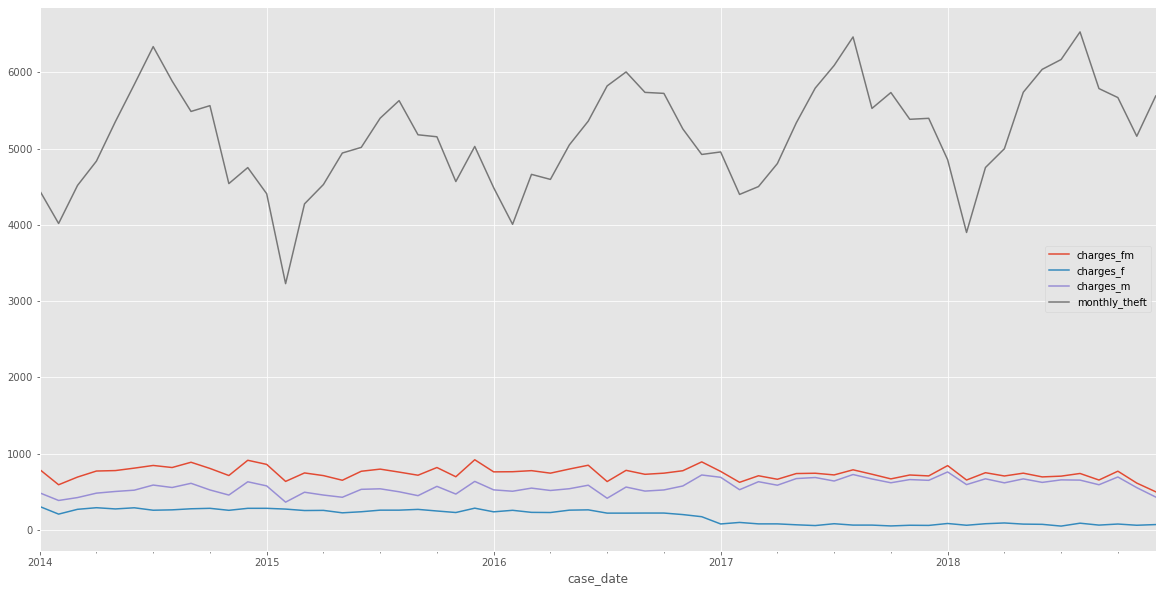

In [10]:
df[['charges_fm', 'charges_f','charges_m','monthly_theft']].plot()

Retail thefts show no large shock after Kim Foxx's change in policy in a seasonal decomposition. Overall thefts were trending upward well before Kim Foxx took office and implemented her policy. We can use overall time series as a covariate.

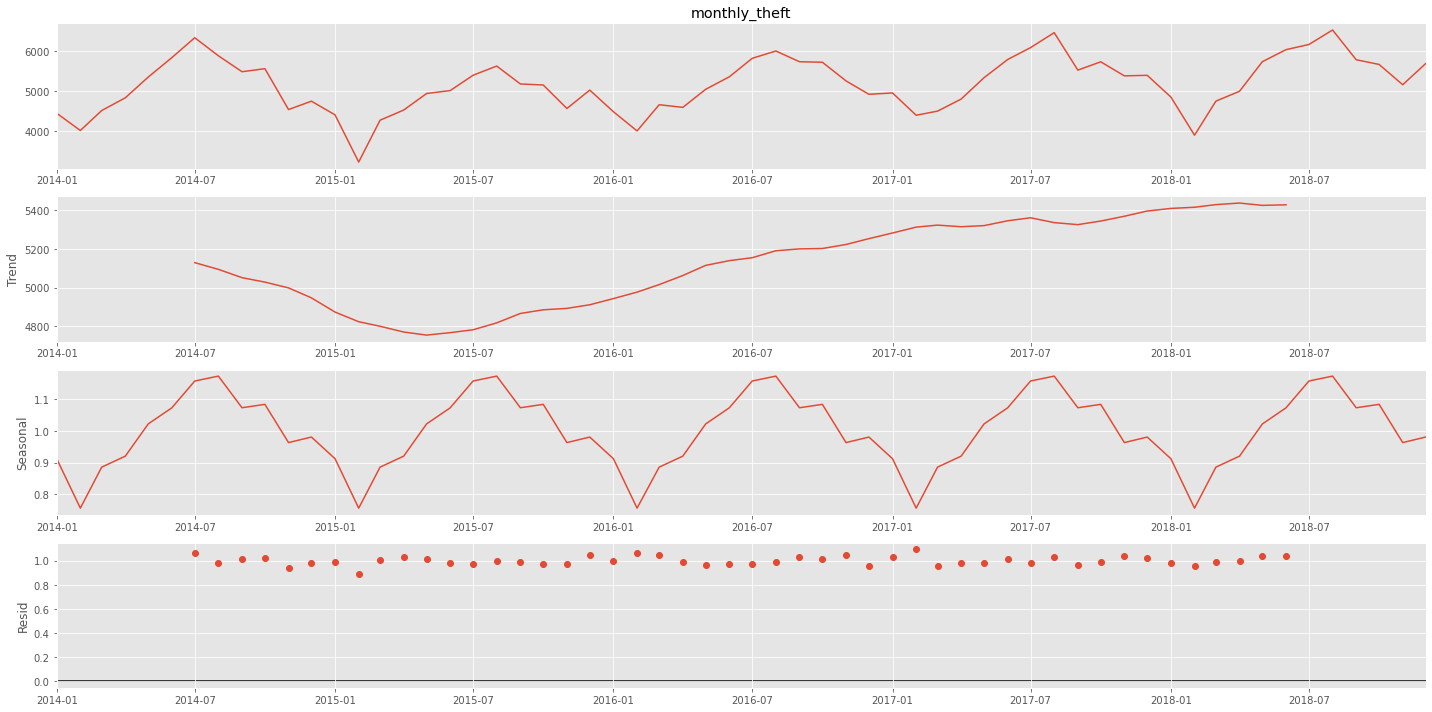

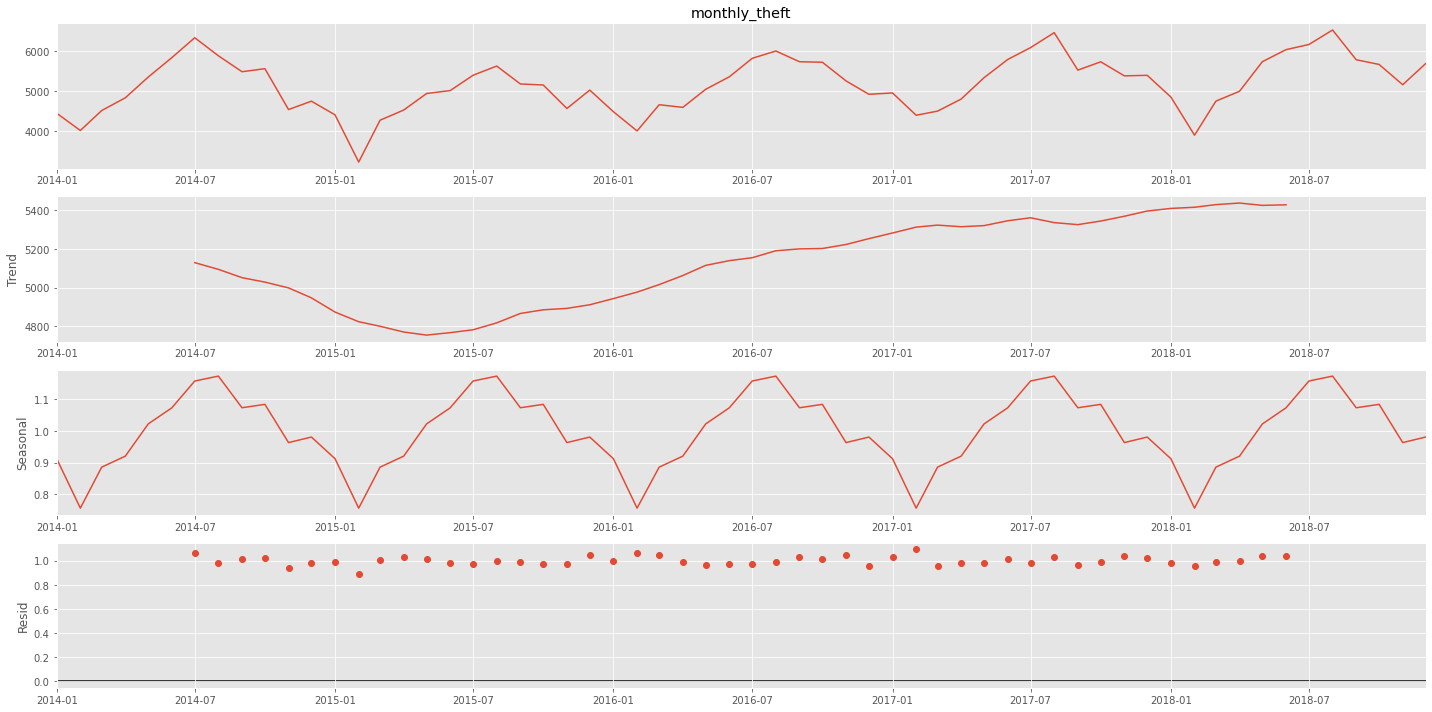

In [11]:
seasonal_decompose(df['monthly_theft'], model="multiplicative").plot()

<AxesSubplot:xlabel='case_date'>

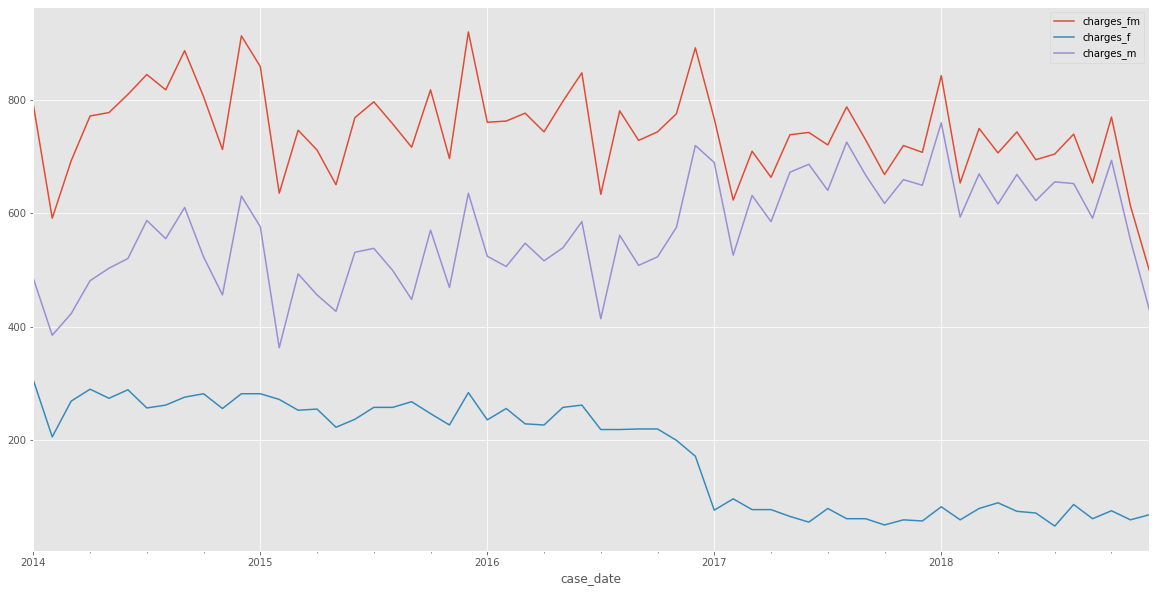

In [12]:
df.reset_index()[['charges_fm', 'charges_f','charges_m','case_date']].groupby('case_date').sum().plot()

### Define Causal Impact Model

In [13]:
def run_causal_impact(dataframe, cols, pre_period, post_period, model=None):
    
    if model == None:
        ci = CausalImpact(dataframe[cols], pre_period=pre_period, post_period=post_period, model_args={'prior_level_sd':0.01, 'fit_method': 'vi'})
    else:
        ci = CausalImpact(dataframe[cols], pre_period=pre_period, post_period=post_period, model_args={'prior_level_sd':0.01,'nseasons':4, 'fit_method': 'vi'}, model=model)
    
    figsize = (20, 6)
    print(f"Summary results for model {cols}:{ci.summary()}")
    print(ci.plot())
    
    return [ci, ci.summary(), ci.summary('report')]

# Run Causal Impact on Felony Thefts

Review original Kim Foxx Effect methods [here](https://projects.chicagoreporter.com/kim-foxx-prosecutions-20191024/#method).

Overview on model args [here](https://stats.stackexchange.com/questions/209426/predictions-from-bsts-model-in-r-are-failing-completely).

Run a univariate model and then one with covariates.

# Run Univariate Models

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Summary results for model charges_fm:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    713.04      

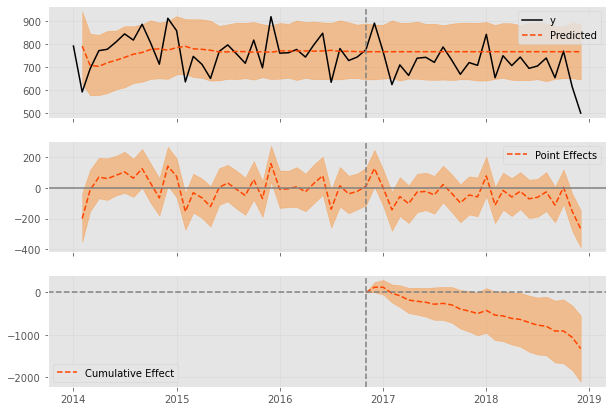

None
Summary results for model charges_f:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    74.4               1860.0
Prediction (s.d.)         252.72 (5.5)       6318.1 (137.61)
95% CI                    [241.75, 263.33]   [6043.76, 6583.17]

Absolute effect (s.d.)    -178.32 (5.5)      -4458.1 (137.61)
95% CI                    [-188.93, -167.35] [-4723.17, -4183.76]

Relative effect (s.d.)    -70.56% (2.18%)    -70.56% (2.18%)
95% CI                    [-74.76%, -66.22%] [-74.76%, -66.22%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


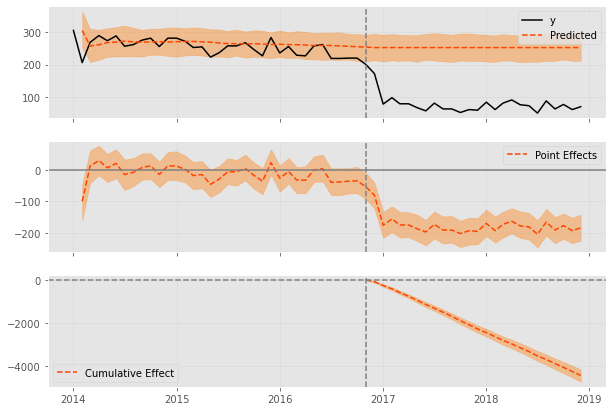

None
Summary results for model charges_m:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    638.64             15966.0
Prediction (s.d.)         513.4 (13.75)      12835.08 (343.75)
95% CI                    [488.14, 542.04]   [12203.53, 13550.99]

Absolute effect (s.d.)    125.24 (13.75)     3130.92 (343.75)
95% CI                    [96.6, 150.5]      [2415.01, 3762.47]

Relative effect (s.d.)    24.39% (2.68%)     24.39% (2.68%)
95% CI                    [18.82%, 29.31%]   [18.82%, 29.31%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


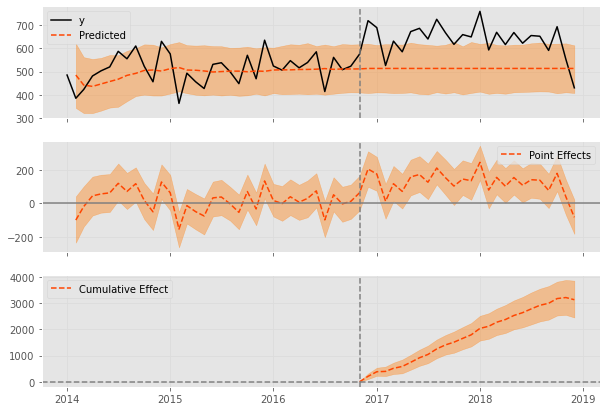

None


In [14]:
uni_all_result, uni_fel_result, uni_misd_result = [run_causal_impact(dataframe=df, cols=col, pre_period=PRE_PERIOD, post_period=POST_PERIOD) for col in UNIVARIATE]

# Run Multivariate Models

Summary results for model ['charges_fm', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    713.04             17826.0
Prediction (s.d.)         759.9 (19.57)      18997.61 (489.25)
95% CI                    [721.03, 797.74]   [18025.65, 19943.49]

Absolute effect (s.d.)    -46.86 (19.57)     -1171.61 (489.25)
95% CI                    [-84.7, -7.99]     [-2117.49, -199.65]

Relative effect (s.d.)    -6.17% (2.58%)     -6.17% (2.58%)
95% CI                    [-11.15%, -1.05%]  [-11.15%, -1.05%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 99.0%

For more details run the command: print(impact.summary('report'))


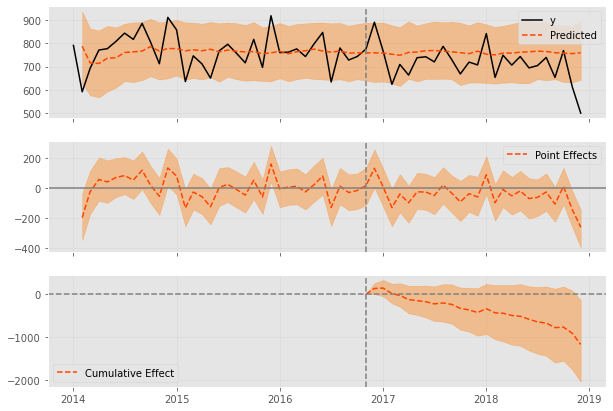

None
Summary results for model ['charges_f', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    74.4               1860.0
Prediction (s.d.)         246.38 (8.06)      6159.43 (201.46)
95% CI                    [228.32, 259.91]   [5707.96, 6497.66]

Absolute effect (s.d.)    -171.98 (8.06)     -4299.43 (201.46)
95% CI                    [-185.51, -153.92] [-4637.66, -3847.96]

Relative effect (s.d.)    -69.8% (3.27%)     -69.8% (3.27%)
95% CI                    [-75.29%, -62.47%] [-75.29%, -62.47%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


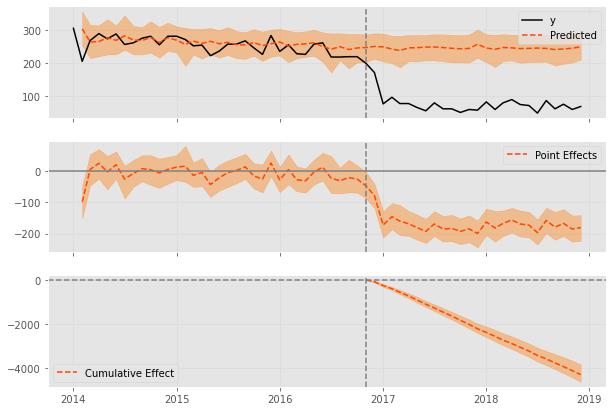

None
Summary results for model ['charges_m', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    638.64             15966.0
Prediction (s.d.)         517.14 (18.58)     12928.46 (464.56)
95% CI                    [482.08, 554.92]   [12051.97, 13873.03]

Absolute effect (s.d.)    121.5 (18.58)      3037.54 (464.56)
95% CI                    [83.72, 156.56]    [2092.97, 3914.03]

Relative effect (s.d.)    23.5% (3.59%)      23.5% (3.59%)
95% CI                    [16.19%, 30.27%]   [16.19%, 30.27%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 99.1%

For more details run the command: print(impact.summary('report'))


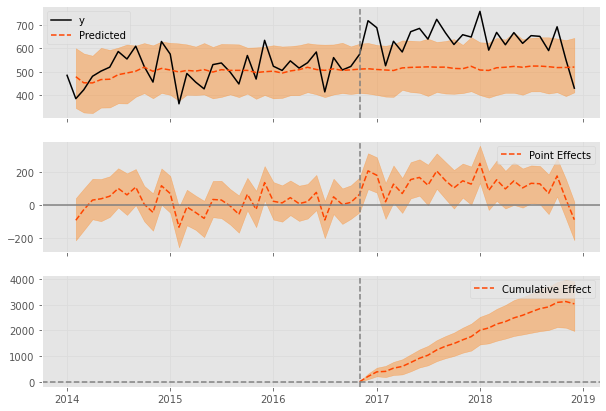

None


In [15]:
multi_all_result, mutli_fel_result, multi_misd_result = [run_causal_impact(dataframe=df, cols=col, pre_period=PRE_PERIOD, post_period=POST_PERIOD) for col in MULTIVARIATE]

In [16]:
multi_all_result[0].inferences[multi_all_result[0].inferences.index>= '2016-12-01' ]['complete_preds_means']

2016-12-01    758.903992
2017-01-01    757.870056
2017-02-01    753.000549
2017-03-01    748.582642
2017-04-01    760.840332
2017-05-01    762.673889
2017-06-01    768.165405
2017-07-01    769.085510
2017-08-01    766.260254
2017-09-01    763.303711
2017-10-01    759.583740
2017-11-01    755.621521
2017-12-01    766.180603
2018-01-01    753.019714
2018-02-01    750.291199
2018-03-01    757.808350
2018-04-01    757.886169
2018-05-01    761.750305
2018-06-01    763.651123
2018-07-01    765.974854
2018-08-01    764.992493
2018-09-01    759.675781
2018-10-01    757.502380
2018-11-01    755.626099
2018-12-01    759.362366
Freq: MS, Name: complete_preds_means, dtype: float32

In [17]:
multi_all_result[0].data[multi_all_result[0].data.index >= '2016-12-01']['charges_fm']

case_date
2016-12-01    891.0
2017-01-01    766.0
2017-02-01    623.0
2017-03-01    709.0
2017-04-01    663.0
2017-05-01    738.0
2017-06-01    742.0
2017-07-01    720.0
2017-08-01    787.0
2017-09-01    729.0
2017-10-01    668.0
2017-11-01    719.0
2017-12-01    707.0
2018-01-01    842.0
2018-02-01    653.0
2018-03-01    749.0
2018-04-01    706.0
2018-05-01    743.0
2018-06-01    694.0
2018-07-01    704.0
2018-08-01    739.0
2018-09-01    653.0
2018-10-01    769.0
2018-11-01    613.0
2018-12-01    499.0
Name: charges_fm, dtype: float64

### Calculate MAPE to Evaluate Pre-Prediction Fit

[What is MAPE? What is a "good" MAPE Score?](https://stephenallwright.com/good-mape-score/)

- The lower the percentage, the more accurate the model, so 10% is better than 20%
- A perfect MAPE score would be inappropriate for this project we may overfit a time series.
- A good MAPE is arbitray and domain specific, but rule of thumb says < 10 % is very good.

There are no large outliers in the pre-prediction dataset or zero values, as a result MAPE serves as a reliable error metric for this forecasting project.

In [18]:
from sklearn.metrics import mean_absolute_percentage_error

### The Multivariate Model Improves Pre-prediction Fit

The multivariate model provides a slight improvement to the pre-prediction fit. This is especially true for all thefts and all misdemeanor retail thefts.

In [19]:
mape_uni = []
for offense,model in zip(["all", "felony", "misdemeanor"],[uni_all_result, uni_fel_result, uni_misd_result]):
    
    mape = mean_absolute_percentage_error(model[0].data[model[0].data.index <= '2016-12-01'],\
                                  model[0].inferences[model[0].inferences.index <= '2016-12-01' ]['complete_preds_means'])

    print(f"The univariate model for {offense} retail thefts has a pre-prediction MAPE of {mape}")
    mape_uni.append(mape)

The univariate model for all retail thefts has a pre-prediction MAPE of 0.08406525571699965
The univariate model for felony retail thefts has a pre-prediction MAPE of 0.10383050452435985
The univariate model for misdemeanor retail thefts has a pre-prediction MAPE of 0.11334731858211956


In [20]:
mape_multi = []
mape_offense = []
for offense,model in zip(["all", "felony", "misdemeanor"],[multi_all_result, mutli_fel_result, multi_misd_result]):
    
    mape = mean_absolute_percentage_error(model[0].data[model[0].data.index <= '2016-12-01'].iloc[:, 0],\
                              model[0].inferences[model[0].inferences.index <= '2016-12-01' ]['complete_preds_means'])
    

    print(f"The multivariate model for {offense} retail thefts has a pre-prediction MAPE of {mape}")
    
    mape_multi.append(mape)
    mape_offense.append(offense)

The multivariate model for all retail thefts has a pre-prediction MAPE of 0.07864274183166052
The multivariate model for felony retail thefts has a pre-prediction MAPE of 0.09191652624322541
The multivariate model for misdemeanor retail thefts has a pre-prediction MAPE of 0.1069398450851435


### Mape Table

In [29]:
mape_results = pd.DataFrame(data=[mape_offense,mape_uni,mape_multi] ).transpose().rename(columns={0:"Offense", 1:"Univariate MAPE", 2:"Multivariate MAPE"})
mape_results.to_csv(r'C:\Users\brand\OneDrive\Documents\grad-school\pui\kim-fox-effect-revisited\data\mape.csv')

In [30]:
mape_results

,Offense,Univariate MAPE,Multivariate MAPE
0,all,0.084065,0.078643
1,felony,0.103831,0.091917
2,misdemeanor,0.113347,0.10694


### Save Results

### Run Data Without Past Two Months

A review of the data provided by the Circuit reveals a potential data quality issue with misdemeanor data. 

A decline consistent with a delay in data entry rather than an actual trend exists for several misdemeanor offenses. A similar break in trend across multiple offenses occurs duing the same time period. Overall counts during that time also look historically low when compared to the other time series during similar months.

Affected months include 12-2018 & 11-2017. The following offense categories are affected:

- [criminal damage and trespass to property](https://charges.thecircuit.cc/en/criminal-damage-and-trespass-to-property/)
- [theft](https://charges.thecircuit.cc/en/theft/)
- [Deceptive Practices](https://charges.thecircuit.cc/en/deceptive-practices/)
- [Other offenses](https://charges.thecircuit.cc/en/other-offenses/)
- [Battery](https://charges.thecircuit.cc/en/battery/?charge=25-battery)


This is not true for all offenses.

- [Domestic Battery](https://charges.thecircuit.cc/en/battery/?charge=31-domestic-battery)

### Update Post Period Range

Results for the most part stay consistent. However, we can [*narrowly*] no longer rule out that the decline in overall felony and misdemeanor retail thefts was due to Kim Foxx's policy at a 95% level.

In [23]:
POST_PERIOD_FIX = ['2016-12-01', '2018-10-01']

Summary results for model ['charges_fm', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    726.7              16714.0
Prediction (s.d.)         753.55 (21.06)     17331.67 (484.49)
95% CI                    [708.14, 790.71]   [16287.19, 18186.34]

Absolute effect (s.d.)    -26.86 (21.06)     -617.67 (484.49)
95% CI                    [-64.01, 18.56]    [-1472.34, 426.81]

Relative effect (s.d.)    -3.56% (2.8%)      -3.56% (2.8%)
95% CI                    [-8.5%, 2.46%]     [-8.5%, 2.46%]

Posterior tail-area probability p: 0.1
Posterior prob. of a causal effect: 90.41%

For more details run the command: print(impact.summary('report'))


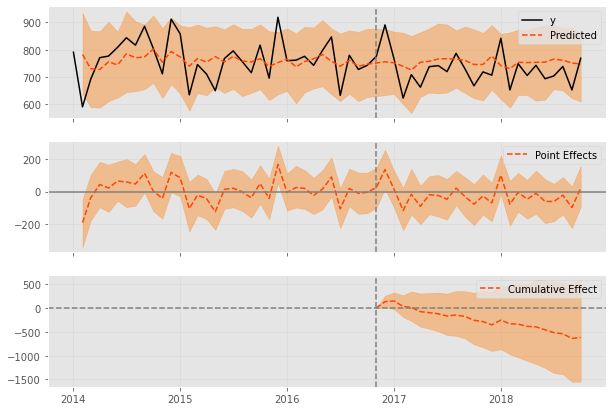

None
Summary results for model ['charges_f', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    75.26              1731.0
Prediction (s.d.)         248.17 (8.67)      5707.99 (199.42)
95% CI                    [227.08, 261.06]   [5222.76, 6004.46]

Absolute effect (s.d.)    -172.91 (8.67)     -3976.99 (199.42)
95% CI                    [-185.8, -151.82]  [-4273.46, -3491.76]

Relative effect (s.d.)    -69.67% (3.49%)    -69.67% (3.49%)
95% CI                    [-74.87%, -61.17%] [-74.87%, -61.17%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


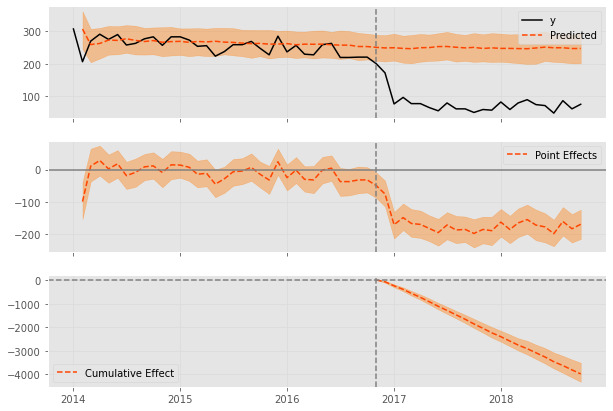

None
Summary results for model ['charges_m', 'monthly_retail_theft_arrest', 'Value', 'PRCP', 'TAVG']:Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    651.43             14983.0
Prediction (s.d.)         519.33 (30.62)     11944.57 (704.19)
95% CI                    [479.81, 599.83]   [11035.7, 13796.07]

Absolute effect (s.d.)    132.11 (30.62)     3038.43 (704.19)
95% CI                    [51.61, 171.62]    [1186.93, 3947.3]

Relative effect (s.d.)    25.44% (5.9%)      25.44% (5.9%)
95% CI                    [9.94%, 33.05%]    [9.94%, 33.05%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


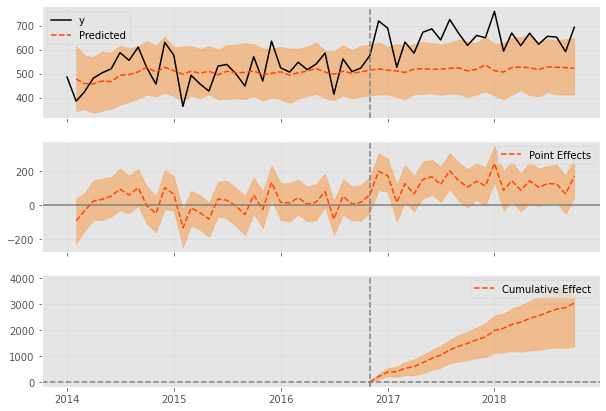

None


In [24]:
multi_all_result, mutli_fel_result, multi_misd_result = [run_causal_impact(dataframe=df.head(-2), cols=col, pre_period=PRE_PERIOD, post_period=POST_PERIOD_FIX) for col in MULTIVARIATE]

### Consider BackTesting and Then Calculating MAPE

If we picked a random date to fit the time series, would we find a statistically significant effect?

Consider using backtesting.

### Consider Lagged Covariates

Perhaps incidents take on average 7 days to be brought for prosecution. If we lagged theft incidents, this should improve correlation.

In [25]:
df['charges_f']#.head(2)

case_date
2014-01-01    306.0
2014-02-01    206.0
2014-03-01    269.0
2014-04-01    290.0
2014-05-01    274.0
2014-06-01    289.0
2014-07-01    257.0
2014-08-01    262.0
2014-09-01    276.0
2014-10-01    282.0
2014-11-01    256.0
2014-12-01    282.0
2015-01-01    282.0
2015-02-01    272.0
2015-03-01    253.0
2015-04-01    255.0
2015-05-01    223.0
2015-06-01    237.0
2015-07-01    258.0
2015-08-01    258.0
2015-09-01    268.0
2015-10-01    247.0
2015-11-01    227.0
2015-12-01    284.0
2016-01-01    236.0
2016-02-01    256.0
2016-03-01    229.0
2016-04-01    227.0
2016-05-01    258.0
2016-06-01    262.0
2016-07-01    219.0
2016-08-01    219.0
2016-09-01    220.0
2016-10-01    220.0
2016-11-01    200.0
2016-12-01    172.0
2017-01-01     77.0
2017-02-01     97.0
2017-03-01     78.0
2017-04-01     78.0
2017-05-01     66.0
2017-06-01     56.0
2017-07-01     80.0
2017-08-01     62.0
2017-09-01     62.0
2017-10-01     51.0
2017-11-01     60.0
2017-12-01     58.0
2018-01-01     83.0
2018-02-01

### Need to Fit and Pass a STS Time Series Model

[STS Model Walktrough](https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083)

[STS Model Blog Post](https://juanitorduz.github.io/intro_sts_tfp/)

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [27]:
model = SARIMAX(df[df.index <'2016-12-01']['charges_f'], 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()
forecast = result.predict(start = len(df[df.index <'2016-12-01']), 
                          end = (len(df[df.index <'2016-12-01'])-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')

C:\Users\brand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\brand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\brand\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\brand\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
result.

SyntaxError: invalid syntax (<ipython-input-28-47c30cf7607e>, line 1)

In [ ]:
df.join(forecast)[['Forecast', 'charges_f']].plot()

In [ ]:
df.join(forecast)